In [2]:
import yaml
import numpy as np

### Loading an experiment file

In [3]:
def read_experiments(filename, verbose=True):
    with open(r''+filename) as file:
        experiments = yaml.full_load(file)
        if verbose :
            for exp, content in experiments.items():
                print(key, ":", content)
        return experiments

In [3]:
exp = read_experiments('exp.yaml', False)

In [4]:
exp

{'Experience1': {'nb_steps': 1000,
  'nb_sync': 100,
  'tasks': 3,
  'Type1': {'number': 3,
   'type': 'RegretMatching',
   'spec': {'intertia': 0.1, 'fadding': 0.2}},
  'Type2': {'number': 2, 'type': 'FictiousPlay'},
  'Type3': {'number': 3, 'type': 'Random'}},
 'Experience2': {'tasks': 3,
  'Type1': {'number': 3,
   'type': 'RegretMatching',
   'spec': {'intertia': 0.1, 'fadding': 0.2}},
  'Type2': {'number': 2, 'type': 'FictiousPlay'},
  'Type3': {'number': 1, 'type': 'Random'}}}

### Generating experiments (all combinations)

In [5]:
# Available Agent Types :
types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpacialAdaptative"}

In [6]:
nb_vehicles = 3 # for 3 vehicles and 4 tasks, 125 possible combinations
nb_tasks = 4

In [7]:
alloc_dim = np.zeros([len(types)]*nb_vehicles)

In [8]:
alloc_dim.shape

(5, 5, 5)

In [9]:
allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]

In [10]:
len(allAlloc)

125

#### Creating an experiment file containing an experiment for each possible combination with 5 possible types of players, with 4 tasks and 3 players.

In [3]:
def create_experiments(nb_steps, nb_agents, nb_tasks, nb_sync=100):
    # Available Types :
    types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpatialAdaptative"}
    alloc_dim = np.zeros([len(types)]*nb_vehicles)
    allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]
    repartitions = []
    exp = {}
    expId = 1
    for a in allAlloc:
        seen = []
        exp_dict = {}
        exp_dict['nb_sync'] = int(nb_sync)
        exp_dict['tasks'] = int(nb_tasks)
        typeId = 1
        repartition = np.zeros(len(types))
        for t in a :
            type_dict={}
            str_type = types[t]
            #print(seen)
            if str_type not in seen :
                seen.append(str_type)
                type_dict["type"] = str_type
                cnt = int((np.array(a)==t).sum())
                type_dict["number"] = cnt
                repartition[t] = cnt
                if str_type == "RegretMatching":
                    # default values
                    dict_spec = {"inertia": 0.1, "fadding" : 0.2}
                    type_dict["spec"] = dict_spec
                # save the agent params
                exp_dict["Type"+str(typeId)] = type_dict
                typeId += 1
        already_done = np.sum([1 if np.all(repartition == r) else 0 for r in repartitions])
        if already_done < 1 :
            # save the experiment setup
            exp["Experience"+str(expId)] = exp_dict
            expId += 1
            # remember done repartitions
            repartitions.append(repartition)
            #print(repartitions)
    return exp

#### The obtained dict (containing all the experiments setup)

In [12]:
exp_outp = create_experiments(100, 3, 4, nb_sync=100)

In [13]:
exp_outp

{'Experience1': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 3,
   'spec': {'inertia': 0.1, 'fadding': 0.2}}},
 'Experience2': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'FictitiousPlay', 'number': 1}},
 'Experience3': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'Random', 'number': 1}},
 'Experience4': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'BestResponse', 'number': 1}},
 'Experience5': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {'type': 'RegretMatching',
   'number': 2,
   'spec': {'inertia': 0.1, 'fadding': 0.2}},
  'Type2': {'type': 'SpatialAdaptative', 'number': 1}},
 'Experience6': {'nb_sync': 100,
  'tasks': 4,
  'Type1': {

### Saving an experiment file

In [45]:
def write_exp_file(filename, exp):
    with open(r''+str(filename), 'w') as file:
        yaml.dump(exp, file)

In [46]:
write_exp_file("exp_3vehicles_4tasks.yaml", exp_outp)

### Run an experiment from yaml file

In [4]:
import threading
import time
import logging
from Environnement import *
from Simulation import *
from Player import *
from utils import *
from Functions import *
import re

logging.basicConfig(level=logging.DEBUG,
                    format='[%(levelname)s] (%(threadName)) : %(message)s',
                    )


#### Reading the experiment saved just before

In [5]:
myexp = read_experiments("exp_3vehicles_4tasks.yaml", False)

In [6]:
print(myexp)

{'Experience1': {'Type1': {'number': 3, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'nb_sync': 100, 'tasks': 4}, 'Experience10': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 2, 'type': 'Random'}, 'nb_sync': 100, 'tasks': 4}, 'Experience11': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 1, 'type': 'Random'}, 'Type3': {'number': 1, 'type': 'BestResponse'}, 'nb_sync': 100, 'tasks': 4}, 'Experience12': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 1, 'type': 'Random'}, 'Type3': {'number': 1, 'type': 'SpatialAdaptative'}, 'nb_sync': 100, 'tasks': 4}, 'Experience13': {'Type1': {'number': 1, 'spec': {'fadding': 0.2, 'inertia': 0.1}, 'type': 'RegretMatching'}, 'Type2': {'number': 2, 'type': 'BestResponse'}, 'nb_sync': 100, 'tasks': 4}, 'Experience14': {'Type1': {'number'

#### Simple factory to create the actor we want

In [7]:
def getAgent(env, id_a, type_a, fadding = 0, inertia = 0):
    if type_a == "Random":
        return RandomPlayer(env, id_a)
    if type_a == "FictitiousPlay":
        return FPPlayer(env, id_a)
    if type_a == "RegretMatching":
        return RegretMatchingPlayer(env, id_a)
    if type_a == "BestResponse":
        return BRPlayer(env, id_a)
    if type_a == "SpatialAdaptative":
        return SAPlayer(env, id_a)
    if type_a == "SpatialFictitious":
        return SpatialFictiousPlayPlayer(env, id_a)
    if type_a == "GeneralizedRegret":
        return GeneralizedRegretMatchingPlayer(env, id_a, fadding_factor = fadding, inertia_factor = inertia)

#### We define the metric we use for the plot

In [14]:
def metric(m, utilities):
    if m == "sum":
        return np.sum(utilities)
    # TODO : add other metrics

#### We run the experiments (plots in the output)

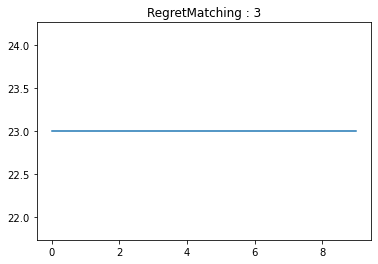

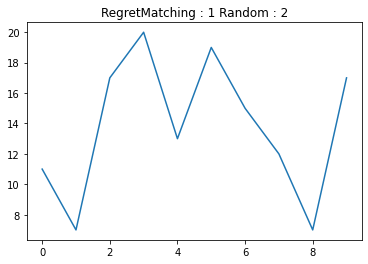

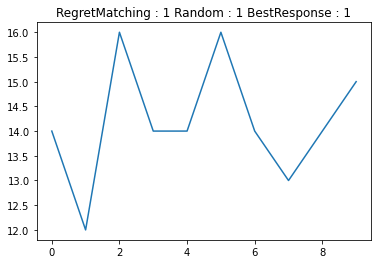

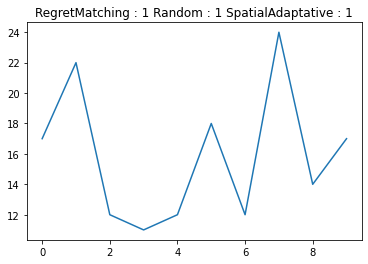

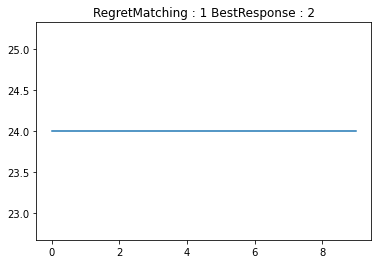

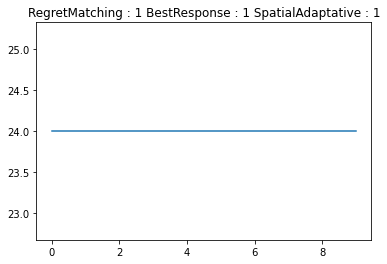

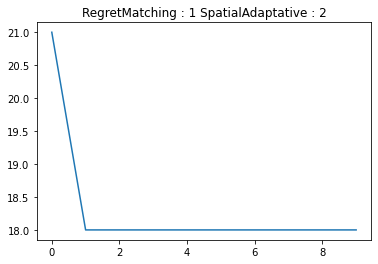

[DEBUG] (Player 0  ) Expected utility  [1.203125 1.234375 1.265625 1.296875]
[DEBUG] (Player 1  ) Expected utility  [0.859375 1.171875 0.984375 1.203125]
[DEBUG] (Player 0  ) Expected utility  [1.203125 1.234375 1.265625 1.296875]
[DEBUG] (Player 2  ) Expected utility  [1.046875 1.3125   1.203125 1.1875  ]
[DEBUG] (Player 1  ) Expected utility  [0.859375 1.171875 0.984375 1.203125]
[DEBUG] (Player 0  ) Expected utility  [0.9625 0.9875 1.0125 2.075 ]
[DEBUG] (Player 2  ) Expected utility  [1.1    1.3375 1.1875 1.225 ]
[DEBUG] (Player 1  ) Expected utility  [0.71 0.82 0.72 2.1 ]
[DEBUG] (Player 0  ) Expected utility  [0.94 1.   1.07 2.08]
[DEBUG] (Player 0  ) Expected utility  [0.72       0.84666667 0.81333333 2.56      ]
[DEBUG] (Player 1  ) Expected utility  [0.736 0.768 0.704 2.224]
[DEBUG] (Player 2  ) Expected utility  [0.832 2.288 0.872 1.024]
[DEBUG] (Player 0  ) Expected utility  [0.72       0.84666667 0.81333333 2.56      ]
[DEBUG] (Player 1  ) Expected utility  [0.61111111 0.57

[DEBUG] (Player 1  ) Expected utility  [0.12941919 0.04835859 0.05441919 6.9354798 ]
[DEBUG] (Player 2  ) Expected utility  [0.11495215 5.72248804 0.17069378 0.37416268]
[DEBUG] (Player 0  ) Expected utility  [0.16244019 0.2861244  0.15358852 4.78074163]
[DEBUG] (Player 1  ) Expected utility  [0.12870813 0.04748804 0.0534689  6.95454545]
[DEBUG] (Player 2  ) Expected utility  [0.11495215 5.72248804 0.17069378 0.37416268]
[DEBUG] (Player 0  ) Expected utility  [0.15470494 0.27249943 0.14627478 4.82091593]
[DEBUG] (Player 1  ) Expected utility  [0.12226218 0.0440231  0.04968944 7.02408194]
[DEBUG] (Player 2  ) Expected utility  [0.1068323  5.78457557 0.1615942  0.3573499 ]
[DEBUG] (Player 0  ) Expected utility  [0.15403727 0.27308489 0.14399586 4.83354037]
[DEBUG] (Player 1  ) Expected utility  [0.12163561 0.04327122 0.04886128 7.04140787]
[DEBUG] (Player 2  ) Expected utility  [0.1068323  5.78457557 0.1615942  0.3573499 ]
[DEBUG] (Player 0  ) Expected utility  [0.14703557 0.26067194 0.1

[DEBUG] (Player 1  ) Expected utility  [0.06902617 0.01587302 0.01836122 7.77432432]
[DEBUG] (Player 2  ) Expected utility  [0.04788121 6.30586837 0.0873999  0.20758258]
[DEBUG] (Player 0  ) Expected utility  [0.08435519 0.15780364 0.07042459 5.30009176]
[DEBUG] (Player 1  ) Expected utility  [0.06888138 0.01572406 0.01818485 7.77996747]
[DEBUG] (Player 2  ) Expected utility  [0.04788121 6.30586837 0.0873999  0.20758258]
[DEBUG] (Player 0  ) Expected utility  [0.08213532 0.15365091 0.06857131 5.31239847]
[DEBUG] (Player 1  ) Expected utility  [0.06683657 0.01503477 0.01740556 7.80610874]
[DEBUG] (Player 2  ) Expected utility  [0.04609588 6.32459344 0.08492561 0.20233747]
[DEBUG] (Player 0  ) Expected utility  [0.08204221 0.15376187 0.06816347 5.31775018]
[DEBUG] (Player 1  ) Expected utility  [0.06670255 0.01489754 0.01724271 7.81146438]
[DEBUG] (Player 2  ) Expected utility  [0.04609588 6.32459344 0.08492561 0.20233747]
[DEBUG] (Player 0  ) Expected utility  [0.07993857 0.14981926 0.0

[DEBUG] (Player 1  ) Expected utility  [4.51112312e-02 7.70226445e-03 8.98241921e-03 8.13960088e+00]
[DEBUG] (Player 2  ) Expected utility  [0.02915197 6.5194868  0.05960543 0.14664884]
[DEBUG] (Player 2  ) Expected utility  [0.02849358 6.5288085  0.05843854 0.14394665]
[DEBUG] (Player 2  ) Expected utility  [0.02849358 6.5288085  0.05843854 0.14394665]
[DEBUG] (Player 0  ) Expected utility  [0.05926405 0.11321546 0.04666164 5.49876963]
[DEBUG] (Player 1  ) Expected utility  [4.42600759e-02 7.55693871e-03 8.81293960e-03 8.14900357e+00]
[DEBUG] (Player 0  ) Expected utility  [0.05808051 0.11113748 0.04552167 5.50874834]
[DEBUG] (Player 1  ) Expected utility  [4.40976755e-02 7.37048904e-03 8.59670635e-03 8.15797107e+00]
[DEBUG] (Player 0  ) Expected utility  [0.05808051 0.11113748 0.04552167 5.50874834]
[DEBUG] (Player 0  ) Expected utility  [0.05700986 0.10909795 0.04465148 5.51670858]
[DEBUG] (Player 1  ) Expected utility  [4.32162272e-02 7.14449017e-03 8.33841386e-03 8.17061043e+00]
[

[DEBUG] (Player 1  ) Expected utility  [3.38834799e-02 4.62568632e-03 5.41847392e-03 8.32969481e+00]
[DEBUG] (Player 2  ) Expected utility  [0.02065179 6.6315536  0.04524458 0.11334897]
[DEBUG] (Player 0  ) Expected utility  [0.04571041 0.08823891 0.03483141 5.60792385]
[DEBUG] (Player 1  ) Expected utility  [3.33851934e-02 4.55766152e-03 5.33879048e-03 8.33543679e+00]
[DEBUG] (Player 2  ) Expected utility  [0.02059986 6.63264022 0.04522478 0.1133799 ]
[DEBUG] (Player 0  ) Expected utility  [0.04502404 0.08695998 0.03424906 5.61353488]
[DEBUG] (Player 1  ) Expected utility  [3.33522033e-02 4.51289945e-03 5.28890189e-03 8.33771690e+00]
[DEBUG] (Player 2  ) Expected utility  [0.02026917 6.63690387 0.04457211 0.11176721]
[DEBUG] (Player 0  ) Expected utility  [0.04500777 0.08696906 0.03419462 5.61407715]
[DEBUG] (Player 1  ) Expected utility  [3.28465350e-02 4.42628217e-03 5.18613242e-03 8.34489788e+00]
[DEBUG] (Player 2  ) Expected utility  [0.02021943 6.63795915 0.04455317 0.11179683]
[

[DEBUG] (Player 1  ) Expected utility  [2.74412918e-02 3.13267524e-03 3.68048527e-03 8.44594639e+00]
[DEBUG] (Player 1  ) Expected utility  [2.70751998e-02 3.05752627e-03 3.59276829e-03 8.45254013e+00]
[DEBUG] (Player 0  ) Expected utility  [0.03673601 0.07142503 0.02734571 5.68057061]
[DEBUG] (Player 1  ) Expected utility  [2.70751998e-02 3.05752627e-03 3.59276829e-03 8.45254013e+00]
[DEBUG] (Player 1  ) Expected utility  [2.67310740e-02 2.99668060e-03 3.52259378e-03 8.45791329e+00]
[DEBUG] (Player 1  ) Expected utility  [2.67310740e-02 2.99668060e-03 3.52259378e-03 8.45791329e+00]
[DEBUG] (Player 0  ) Expected utility  [0.03630311 0.07059004 0.02699661 5.68554118]
[DEBUG] (Player 1  ) Expected utility  [2.64128469e-02 2.96100583e-03 3.48065814e-03 8.46168914e+00]
[DEBUG] (Player 2  ) Expected utility  [0.0157701  6.70244169 0.03643809 0.09245087]
[DEBUG] (Player 0  ) Expected utility  [0.03630311 0.07059004 0.02699661 5.68554118]
[DEBUG] (Player 1  ) Expected utility  [2.64128469e-02

[DEBUG] (Player 0  ) Expected utility  [0.03104806 0.06060404 0.02277616 5.72934065]
[DEBUG] (Player 2  ) Expected utility  [0.01318931 6.74274035 0.03146348 0.08040035]
[DEBUG] (Player 1  ) Expected utility  [2.23382010e-02 2.18444205e-03 2.57302584e-03 8.53664925e+00]
[DEBUG] (Player 0  ) Expected utility  [0.03104806 0.06060404 0.02277616 5.72934065]
[DEBUG] (Player 2  ) Expected utility  [0.01305472 6.74493621 0.03114242 0.07957994]
[DEBUG] (Player 1  ) Expected utility  [2.21046365e-02 2.15503641e-03 2.53787353e-03 8.54017897e+00]
[DEBUG] (Player 1  ) Expected utility  [2.20937472e-02 2.14055625e-03 2.52160858e-03 8.54126922e+00]
[DEBUG] (Player 2  ) Expected utility  [0.01302658 6.74536022 0.03113697 0.07960037]
[DEBUG] (Player 0  ) Expected utility  [0.03072989 0.05999804 0.02252269 5.73202651]
[DEBUG] (Player 1  ) Expected utility  [2.18728097e-02 2.11915069e-03 2.49639250e-03 8.54393836e+00]
[DEBUG] (Player 2  ) Expected utility  [0.01287828 6.74801347 0.03081624 0.07880624]
[

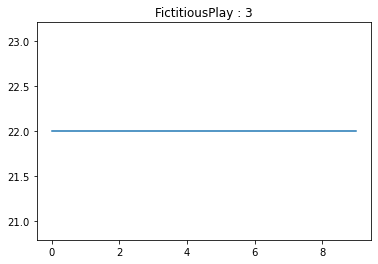

[DEBUG] (Player 0  ) Expected utility  [1.328125 1.15625  1.       1.140625]
[DEBUG] (Player 1  ) Expected utility  [1.421875 0.890625 0.765625 1.015625]
[DEBUG] (Player 0  ) Expected utility  [1.328125 1.15625  1.       1.140625]
[DEBUG] (Player 1  ) Expected utility  [1.33482143 0.91071429 0.66964286 0.89732143]
[DEBUG] (Player 0  ) Expected utility  [2.02857143 0.87142857 0.78214286 0.8       ]
[DEBUG] (Player 1  ) Expected utility  [2.27428571 0.76       0.62857143 0.62571429]
[DEBUG] (Player 0  ) Expected utility  [2.06285714 0.77142857 0.86285714 0.87428571]
[DEBUG] (Player 1  ) Expected utility  [2.27428571 0.76       0.62857143 0.62571429]
[DEBUG] (Player 0  ) Expected utility  [2.57857143 0.64285714 0.71904762 0.72857143]
[DEBUG] (Player 1  ) Expected utility  [2.95833333 0.65079365 0.57539683 0.4702381 ]
[DEBUG] (Player 0  ) Expected utility  [2.60714286 0.58730159 0.76388889 0.76984127]
[DEBUG] (Player 1  ) Expected utility  [2.95833333 0.65079365 0.57539683 0.4702381 ]
[DEB

[DEBUG] (Player 0  ) Expected utility  [4.78128752 0.09303721 0.18952581 0.20078031]
[DEBUG] (Player 1  ) Expected utility  [6.54636855 0.1212485  0.18569928 0.08816026]
[DEBUG] (Player 0  ) Expected utility  [4.78128752 0.09303721 0.18952581 0.20078031]
[DEBUG] (Player 1  ) Expected utility  [6.57345697 0.11706752 0.17929586 0.08512025]
[DEBUG] (Player 0  ) Expected utility  [4.80191649 0.08942435 0.18325523 0.19409666]
[DEBUG] (Player 1  ) Expected utility  [6.58228999 0.11701756 0.17972302 0.084808  ]
[DEBUG] (Player 0  ) Expected utility  [4.80191649 0.08942435 0.18325523 0.19409666]
[DEBUG] (Player 1  ) Expected utility  [6.60760649 0.11311697 0.17373225 0.08198107]
[DEBUG] (Player 0  ) Expected utility  [4.82117647 0.08607843 0.17738562 0.18784314]
[DEBUG] (Player 0  ) Expected utility  [4.82117647 0.08607843 0.17738562 0.18784314]
[DEBUG] (Player 1  ) Expected utility  [6.61588235 0.1130719  0.17411765 0.08169935]
[DEBUG] (Player 0  ) Expected utility  [4.83845667 0.08330171 0.1

[DEBUG] (Player 0  ) Expected utility  [5.05480141 0.05161723 0.10874392 0.10766857]
[DEBUG] (Player 1  ) Expected utility  [7.20495745 0.05610364 0.10428057 0.04454584]
[DEBUG] (Player 0  ) Expected utility  [5.06087056 0.05056308 0.10670322 0.10562812]
[DEBUG] (Player 0  ) Expected utility  [5.06086446 0.05050385 0.10675187 0.10565712]
[DEBUG] (Player 0  ) Expected utility  [5.06671067 0.04955095 0.10473769 0.10366359]
[DEBUG] (Player 0  ) Expected utility  [5.06671067 0.04955095 0.10473769 0.10366359]
[DEBUG] (Player 0  ) Expected utility  [5.07234034 0.04863334 0.1027981  0.10174389]
[DEBUG] (Player 1  ) Expected utility  [7.22130773 0.05501575 0.10256948 0.04357821]
[DEBUG] (Player 0  ) Expected utility  [5.10426312 0.04840749 0.10363619 0.10150892]
[DEBUG] (Player 1  ) Expected utility  [7.17925347 0.05626286 0.10186257 0.04156486]
[DEBUG] (Player 0  ) Expected utility  [5.10972222 0.04752736 0.10175189 0.0996633 ]
[DEBUG] (Player 1  ) Expected utility  [7.18948347 0.05522727 0.1

[DEBUG] (Player 0  ) Expected utility  [5.34306952 0.03340738 0.07257389 0.07292379]
[DEBUG] (Player 0  ) Expected utility  [5.34306952 0.03340738 0.07257389 0.07292379]
[DEBUG] (Player 1  ) Expected utility  [7.23052965 0.04219762 0.0723908  0.02671451]
[DEBUG] (Player 0  ) Expected utility  [5.34584659 0.03297908 0.07164345 0.07198887]
[DEBUG] (Player 0  ) Expected utility  [5.34599329 0.03296109 0.0716585  0.07199943]
[DEBUG] (Player 1  ) Expected utility  [7.23566116 0.04164685 0.07147416 0.02635063]
[DEBUG] (Player 0  ) Expected utility  [5.34870012 0.03254386 0.07075143 0.07108804]
[DEBUG] (Player 1  ) Expected utility  [7.23690143 0.04164416 0.07149707 0.02633412]
[DEBUG] (Player 0  ) Expected utility  [5.34870012 0.03254386 0.07075143 0.07108804]
[DEBUG] (Player 0  ) Expected utility  [5.35148237 0.03211996 0.06988133 0.07020948]
[DEBUG] (Player 1  ) Expected utility  [7.24066282 0.04111026 0.07058044 0.02599651]
[DEBUG] (Player 0  ) Expected utility  [5.35148237 0.03211996 0.0

[DEBUG] (Player 1  ) Expected utility  [7.41204113 0.03095868 0.05576733 0.0223572 ]
[DEBUG] (Player 0  ) Expected utility  [5.25817022 0.02486481 0.05511043 0.05560453]
[DEBUG] (Player 1  ) Expected utility  [7.41431081 0.03065216 0.05521517 0.02213584]
[DEBUG] (Player 0  ) Expected utility  [5.25978619 0.02461247 0.05457678 0.05506399]
[DEBUG] (Player 1  ) Expected utility  [7.41507064 0.03065032 0.05522546 0.02212882]
[DEBUG] (Player 0  ) Expected utility  [5.25978619 0.02461247 0.05457678 0.05506399]
[DEBUG] (Player 1  ) Expected utility  [7.41729605 0.03034983 0.05468403 0.02191188]
[DEBUG] (Player 1  ) Expected utility  [7.41804134 0.03034804 0.05469402 0.02190507]
[DEBUG] (Player 0  ) Expected utility  [5.26137079 0.0243652  0.05405336 0.05453386]
[DEBUG] (Player 1  ) Expected utility  [7.42022376 0.0300534  0.05416301 0.02169239]
[DEBUG] (Player 0  ) Expected utility  [5.26140722 0.02435704 0.05405969 0.05453824]
[DEBUG] (Player 1  ) Expected utility  [7.42022376 0.0300534  0.0

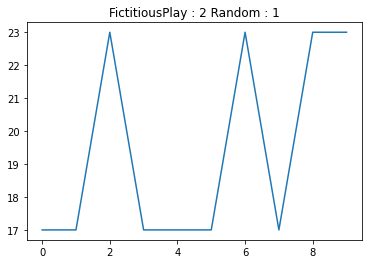

[DEBUG] (Player 0  ) Expected utility  [1.140625 1.390625 0.890625 1.296875]
[DEBUG] (Player 1  ) Expected utility  [1.15625 1.1875  1.21875 1.125  ]
[DEBUG] (Player 0  ) Expected utility  [1.2265625 1.2578125 0.8515625 1.0546875]
[DEBUG] (Player 1  ) Expected utility  [1.35714286 1.58928571 0.83928571 0.99107143]
[DEBUG] (Player 0  ) Expected utility  [1.01071429 1.92142857 0.66785714 0.76071429]
[DEBUG] (Player 1  ) Expected utility  [1.19714286 2.13714286 0.58571429 0.84857143]
[DEBUG] (Player 0  ) Expected utility  [0.98285714 1.73142857 0.68285714 0.72571429]
[DEBUG] (Player 1  ) Expected utility  [1.19714286 2.13714286 0.58571429 0.84857143]
[DEBUG] (Player 0  ) Expected utility  [0.81904762 2.16428571 0.56904762 0.6047619 ]
[DEBUG] (Player 1  ) Expected utility  [1.05952381 2.33333333 0.44047619 0.73809524]
[DEBUG] (Player 0  ) Expected utility  [0.80357143 2.00595238 0.57738095 0.58531746]
[DEBUG] (Player 1  ) Expected utility  [1.05952381 2.33333333 0.44047619 0.73809524]
[DEB

[DEBUG] (Player 0  ) Expected utility  [0.20884604 5.61318277 0.10185324 0.22572779]
[DEBUG] (Player 0  ) Expected utility  [0.20884604 5.61318277 0.10185324 0.22572779]
[DEBUG] (Player 1  ) Expected utility  [0.2319928  2.80237095 0.09588836 0.08185774]
[DEBUG] (Player 0  ) Expected utility  [0.20164445 5.63640974 0.09834106 0.21794407]
[DEBUG] (Player 0  ) Expected utility  [0.20172064 5.63663706 0.09816745 0.21815766]
[DEBUG] (Player 1  ) Expected utility  [0.22448765 2.80604323 0.09208226 0.07893264]
[DEBUG] (Player 0  ) Expected utility  [0.19499662 5.65831643 0.0948952  0.21088573]
[DEBUG] (Player 0  ) Expected utility  [0.19499662 5.65831643 0.0948952  0.21088573]
[DEBUG] (Player 0  ) Expected utility  [0.18870641 5.67859713 0.09183406 0.20408297]
[DEBUG] (Player 1  ) Expected utility  [0.22494929 2.79864773 0.09161596 0.07883705]
[DEBUG] (Player 1  ) Expected utility  [0.21786844 2.80246679 0.08814042 0.07612271]
[DEBUG] (Player 1  ) Expected utility  [0.21786844 2.80246679 0.0

[DEBUG] (Player 0  ) Expected utility  [0.12033613 6.82602591 0.04905627 0.14012848]
[DEBUG] (Player 0  ) Expected utility  [0.12033613 6.82602591 0.04905627 0.14012848]
[DEBUG] (Player 1  ) Expected utility  [0.12206881 3.17458361 0.0534462  0.02836675]
[DEBUG] (Player 1  ) Expected utility  [0.11984626 3.17695766 0.05235157 0.02780085]
[DEBUG] (Player 1  ) Expected utility  [0.11984626 3.17695766 0.05235157 0.02780085]
[DEBUG] (Player 0  ) Expected utility  [0.11806563 6.8339112  0.04813068 0.13748455]
[DEBUG] (Player 0  ) Expected utility  [0.1181057  6.83574035 0.04805627 0.13758185]
[DEBUG] (Player 0  ) Expected utility  [0.11591856 6.84333562 0.04716634 0.13503404]
[DEBUG] (Player 0  ) Expected utility  [0.11591856 6.84333562 0.04716634 0.13503404]
[DEBUG] (Player 0  ) Expected utility  [0.11381095 6.8506547  0.04630877 0.13257888]
[DEBUG] (Player 1  ) Expected utility  [0.11777653 3.17803966 0.0512221  0.02722908]
[DEBUG] (Player 0  ) Expected utility  [0.11381095 6.8506547  0.0

[DEBUG] (Player 0  ) Expected utility  [0.08566853 7.53901819 0.03118611 0.10362048]
[DEBUG] (Player 1  ) Expected utility  [0.08175043 3.42924746 0.03782483 0.01274156]
[DEBUG] (Player 0  ) Expected utility  [0.08455595 7.54304186 0.03078109 0.10227476]
[DEBUG] (Player 1  ) Expected utility  [0.08071505 3.43079617 0.03730453 0.01256335]
[DEBUG] (Player 0  ) Expected utility  [0.08456417 7.54373981 0.03076685 0.10229381]
[DEBUG] (Player 1  ) Expected utility  [0.08071505 3.43079617 0.03730453 0.01256335]
[DEBUG] (Player 1  ) Expected utility  [0.07970555 3.43230487 0.03679832 0.01239003]
[DEBUG] (Player 1  ) Expected utility  [0.07970555 3.43230487 0.03679832 0.01239003]
[DEBUG] (Player 0  ) Expected utility  [0.08348001 7.54766067 0.03037241 0.10098235]
[DEBUG] (Player 1  ) Expected utility  [0.07869662 3.43404275 0.03633251 0.0122332 ]
[DEBUG] (Player 0  ) Expected utility  [0.08349562 7.54900427 0.03034536 0.10101853]
[DEBUG] (Player 1  ) Expected utility  [0.07869662 3.43404275 0.0

[DEBUG] (Player 0  ) Expected utility  [0.06539318 7.82796458 0.02275228 0.08012091]
[DEBUG] (Player 0  ) Expected utility  [0.06539318 7.82796458 0.02275228 0.08012091]
[DEBUG] (Player 1  ) Expected utility  [0.06180407 3.53518088 0.02890994 0.00782273]
[DEBUG] (Player 0  ) Expected utility  [0.06475207 7.83031391 0.02252922 0.07933541]
[DEBUG] (Player 1  ) Expected utility  [0.06120358 3.53616923 0.02861095 0.00773935]
[DEBUG] (Player 0  ) Expected utility  [0.06475591 7.83077315 0.0225227  0.07934419]
[DEBUG] (Player 1  ) Expected utility  [0.06120358 3.53616923 0.02861095 0.00773935]
[DEBUG] (Player 0  ) Expected utility  [0.06412721 7.833077   0.02230403 0.07857386]
[DEBUG] (Player 1  ) Expected utility  [0.06061463 3.53713812 0.02831807 0.00765771]
[DEBUG] (Player 0  ) Expected utility  [0.06413094 7.83352736 0.0222977  0.07858239]
[DEBUG] (Player 1  ) Expected utility  [0.06061463 3.53713812 0.02831807 0.00765771]
[DEBUG] (Player 1  ) Expected utility  [0.06003691 3.53808813 0.0

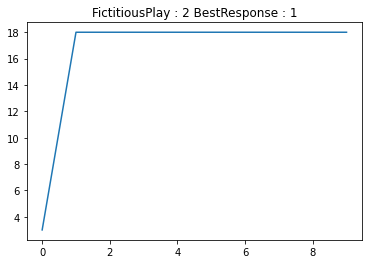

[DEBUG] (Player 0  ) Expected utility  [1.0625   0.859375 1.328125 1.421875]
[DEBUG] (Player 1  ) Expected utility  [1.125    0.8125   1.203125 1.25    ]
[DEBUG] (Player 1  ) Expected utility  [0.76785714 0.36607143 1.14732143 1.25      ]
[DEBUG] (Player 1  ) Expected utility  [0.61428571 0.29285714 0.91785714 2.        ]
[DEBUG] (Player 0  ) Expected utility  [1.0625   0.859375 1.328125 1.421875]
[DEBUG] (Player 1  ) Expected utility  [0.61428571 0.29285714 0.91785714 2.        ]
[DEBUG] (Player 0  ) Expected utility  [0.72857143 0.78285714 1.07714286 2.02857143]
[DEBUG] (Player 1  ) Expected utility  [0.53333333 0.23333333 0.84285714 2.23571429]
[DEBUG] (Player 0  ) Expected utility  [0.67142857 0.67380952 1.16428571 2.09047619]
[DEBUG] (Player 0  ) Expected utility  [0.55952381 0.56150794 0.9702381  2.61309524]
[DEBUG] (Player 1  ) Expected utility  [0.53333333 0.23333333 0.84285714 2.23571429]
[DEBUG] (Player 0  ) Expected utility  [0.55952381 0.56150794 0.9702381  2.61309524]
[DEB

[DEBUG] (Player 0  ) Expected utility  [0.06287515 0.03380102 0.28635204 5.18363595]
[DEBUG] (Player 1  ) Expected utility  [0.11479592 0.01973289 0.25453932 2.28091236]
[DEBUG] (Player 0  ) Expected utility  [0.06070704 0.03263547 0.27647783 5.20508548]
[DEBUG] (Player 1  ) Expected utility  [0.11489423 0.01963199 0.25507099 2.26836424]
[DEBUG] (Player 0  ) Expected utility  [0.06070704 0.03263547 0.27647783 5.20508548]
[DEBUG] (Player 1  ) Expected utility  [0.11093236 0.01895503 0.24627544 2.27775058]
[DEBUG] (Player 0  ) Expected utility  [0.05824882 0.03076403 0.26791751 5.2311359 ]
[DEBUG] (Player 1  ) Expected utility  [0.11102096 0.0188641  0.24675456 2.26599053]
[DEBUG] (Player 0  ) Expected utility  [0.05824882 0.03076403 0.26791751 5.2311359 ]
[DEBUG] (Player 1  ) Expected utility  [0.10732026 0.01823529 0.23852941 2.27470588]
[DEBUG] (Player 0  ) Expected utility  [0.05597723 0.02906388 0.25986717 5.25553447]
[DEBUG] (Player 1  ) Expected utility  [0.10740038 0.01815307 0.2

[DEBUG] (Player 1  ) Expected utility  [0.06045913 0.00664311 0.14377192 2.18261012]
[DEBUG] (Player 0  ) Expected utility  [0.02796954 0.01052624 0.16190691 5.55149436]
[DEBUG] (Player 0  ) Expected utility  [0.02736574 0.01019211 0.15896655 5.55984072]
[DEBUG] (Player 1  ) Expected utility  [0.05931839 0.00651777 0.14105924 2.18513143]
[DEBUG] (Player 0  ) Expected utility  [0.02736574 0.01019211 0.15896655 5.55984072]
[DEBUG] (Player 1  ) Expected utility  [0.0593331  0.00650027 0.14114684 2.18115053]
[DEBUG] (Player 0  ) Expected utility  [0.02678708 0.00987527 0.15613093 5.56788218]
[DEBUG] (Player 1  ) Expected utility  [0.05824823 0.00636336 0.13861581 2.17973632]
[DEBUG] (Player 0  ) Expected utility  [0.02613812 0.00945752 0.15681263 5.56692065]
[DEBUG] (Player 0  ) Expected utility  [0.02566288 0.00928556 0.15396149 5.57287458]
[DEBUG] (Player 1  ) Expected utility  [0.05772034 0.00552984 0.13935507 2.16708462]
[DEBUG] (Player 1  ) Expected utility  [0.05668388 0.00541322 0.1

[DEBUG] (Player 0  ) Expected utility  [1.69758813e-02 4.89383632e-03 1.11743970e-01 5.69224902e+00]
[DEBUG] (Player 0  ) Expected utility  [1.69758813e-02 4.89383632e-03 1.11743970e-01 5.69224902e+00]
[DEBUG] (Player 1  ) Expected utility  [0.04121481 0.00302222 0.10193439 2.12769524]
[DEBUG] (Player 0  ) Expected utility  [1.67582418e-02 4.83109483e-03 1.10311355e-01 5.69520757e+00]
[DEBUG] (Player 1  ) Expected utility  [0.04068665 0.00296414 0.1006824  2.12306809]
[DEBUG] (Player 0  ) Expected utility  [1.67325365e-02 4.78560183e-03 1.10349994e-01 5.69618156e+00]
[DEBUG] (Player 1  ) Expected utility  [0.04068665 0.00296414 0.1006824  2.12306809]
[DEBUG] (Player 1  ) Expected utility  [0.04016267 0.00291993 0.09940271 2.12236678]
[DEBUG] (Player 0  ) Expected utility  [1.65207322e-02 4.72502459e-03 1.08953158e-01 5.69906570e+00]
[DEBUG] (Player 0  ) Expected utility  [1.64960115e-02 4.68127412e-03 1.08990316e-01 5.70001487e+00]
[DEBUG] (Player 0  ) Expected utility  [1.62898114e-02

[DEBUG] (Player 0  ) Expected utility  [1.26810143e-02 3.00455740e-03 8.86579710e-02 5.75878340e+00]
[DEBUG] (Player 1  ) Expected utility  [3.13771505e-02 1.85820011e-03 7.87682616e-02 2.10217898e+00]
[DEBUG] (Player 0  ) Expected utility  [1.25529233e-02 2.97420833e-03 8.77624360e-02 5.76062033e+00]
[DEBUG] (Player 0  ) Expected utility  [1.25529233e-02 2.97420833e-03 8.77624360e-02 5.76062033e+00]
[DEBUG] (Player 1  ) Expected utility  [3.13793350e-02 1.85528757e-03 7.87823288e-02 2.10099920e+00]
[DEBUG] (Player 0  ) Expected utility  [1.24273940e-02 2.94446625e-03 8.68848116e-02 5.76242053e+00]
[DEBUG] (Player 1  ) Expected utility  [3.10644911e-02 1.83372183e-03 7.80001943e-02 2.10051282e+00]
[DEBUG] (Player 0  ) Expected utility  [1.24155012e-02 2.92346542e-03 8.69026807e-02 5.76300214e+00]
[DEBUG] (Player 1  ) Expected utility  [3.10644911e-02 1.83372183e-03 7.80001943e-02 2.10051282e+00]
[DEBUG] (Player 1  ) Expected utility  [3.07559025e-02 1.81264280e-03 7.72334349e-02 2.1000

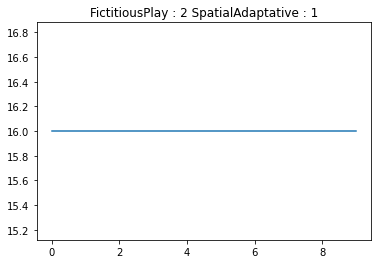

[DEBUG] (Player 2  ) Expected utility  [1.01785714 1.21875    1.29910714 1.44642857]
[DEBUG] (Player 2  ) Expected utility  [1.08928571 1.23214286 1.45153061 1.60331633]
[DEBUG] (Player 2  ) Expected utility  [0.87142857 0.98571429 1.16122449 2.56530612]
[DEBUG] (Player 2  ) Expected utility  [0.87142857 0.98571429 1.16122449 2.56530612]
[DEBUG] (Player 2  ) Expected utility  [0.72619048 0.82142857 0.96768707 3.20663265]
[DEBUG] (Player 2  ) Expected utility  [0.72619048 0.82142857 0.96768707 3.20663265]
[DEBUG] (Player 2  ) Expected utility  [0.62244898 0.70408163 0.82944606 3.66472303]
[DEBUG] (Player 2  ) Expected utility  [0.62244898 0.70408163 0.82944606 3.66472303]
[DEBUG] (Player 2  ) Expected utility  [0.54464286 0.61607143 0.72576531 4.00829082]
[DEBUG] (Player 2  ) Expected utility  [0.54464286 0.61607143 0.72576531 4.00829082]
[DEBUG] (Player 2  ) Expected utility  [0.48412698 0.54761905 0.64512472 4.2755102 ]
[DEBUG] (Player 2  ) Expected utility  [0.48412698 0.54761905 0.6

[DEBUG] (Player 2  ) Expected utility  [0.08915005 0.07917854 0.09043606 4.42005645]
[DEBUG] (Player 2  ) Expected utility  [0.08746797 0.0776846  0.08872972 4.42516241]
[DEBUG] (Player 2  ) Expected utility  [0.08746797 0.0776846  0.08872972 4.42516241]
[DEBUG] (Player 2  ) Expected utility  [0.08876597 0.07712041 0.08927903 4.55786436]
[DEBUG] (Player 2  ) Expected utility  [0.0938359  0.07604076 0.08723054 4.66065809]
[DEBUG] (Player 2  ) Expected utility  [0.09212979 0.0746582  0.08564453 4.66564276]
[DEBUG] (Player 2  ) Expected utility  [0.09212979 0.0746582  0.08564453 4.66564276]
[DEBUG] (Player 2  ) Expected utility  [0.09048462 0.07332502 0.08411516 4.67044939]
[DEBUG] (Player 2  ) Expected utility  [0.09048462 0.07332502 0.08411516 4.67044939]
[DEBUG] (Player 2  ) Expected utility  [0.08889717 0.07203862 0.08263946 4.67508738]
[DEBUG] (Player 2  ) Expected utility  [0.08889717 0.07203862 0.08263946 4.67508738]
[DEBUG] (Player 2  ) Expected utility  [0.08736446 0.07079657 0.0

[DEBUG] (Player 2  ) Expected utility  [0.04318868 0.04075645 0.04871038 5.16125176]
[DEBUG] (Player 2  ) Expected utility  [0.04318868 0.04075645 0.04871038 5.16125176]
[DEBUG] (Player 2  ) Expected utility  [0.04276526 0.04035688 0.04823283 5.16280075]
[DEBUG] (Player 2  ) Expected utility  [0.04276526 0.04035688 0.04823283 5.16280075]
[DEBUG] (Player 2  ) Expected utility  [0.04235006 0.03996506 0.04776455 5.16431967]
[DEBUG] (Player 2  ) Expected utility  [0.04235006 0.03996506 0.04776455 5.16431967]


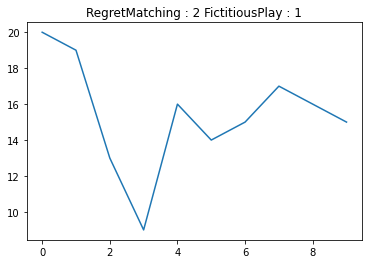

[DEBUG] (Player 0  ) Expected utility  [1.265625 1.265625 1.15625  1.359375]
[DEBUG] (Player 0  ) Expected utility  [1.19515306 1.25255102 1.23469388 1.33928571]
[DEBUG] (Player 0  ) Expected utility  [0.95612245 1.00204082 0.9877551  2.14285714]
[DEBUG] (Player 0  ) Expected utility  [0.95612245 1.00204082 0.9877551  2.14285714]
[DEBUG] (Player 0  ) Expected utility  [0.79676871 0.83503401 0.82312925 2.67857143]
[DEBUG] (Player 0  ) Expected utility  [0.79676871 0.83503401 0.82312925 2.67857143]
[DEBUG] (Player 0  ) Expected utility  [0.68294461 0.71574344 0.70553936 3.06122449]
[DEBUG] (Player 0  ) Expected utility  [0.68294461 0.71574344 0.70553936 3.06122449]
[DEBUG] (Player 0  ) Expected utility  [0.59757653 0.62627551 0.61734694 3.34821429]
[DEBUG] (Player 0  ) Expected utility  [0.59757653 0.62627551 0.61734694 3.34821429]
[DEBUG] (Player 0  ) Expected utility  [0.53117914 0.55668934 0.54875283 3.57142857]
[DEBUG] (Player 0  ) Expected utility  [0.53117914 0.55668934 0.54875283 

[DEBUG] (Player 0  ) Expected utility  [0.09540862 0.0984159  0.08969743 5.20789807]
[DEBUG] (Player 0  ) Expected utility  [0.09360846 0.096559   0.08800502 5.21391412]
[DEBUG] (Player 0  ) Expected utility  [0.09360846 0.096559   0.08800502 5.21391412]
[DEBUG] (Player 0  ) Expected utility  [0.09187497 0.09477087 0.0863753  5.21970736]
[DEBUG] (Player 0  ) Expected utility  [0.09340639 0.09337927 0.08710395 5.28229438]
[DEBUG] (Player 0  ) Expected utility  [0.0917081  0.09168146 0.08552024 5.28794389]
[DEBUG] (Player 0  ) Expected utility  [0.0917081  0.09168146 0.08552024 5.28794389]
[DEBUG] (Player 0  ) Expected utility  [0.09007045 0.09004429 0.08399309 5.29339164]
[DEBUG] (Player 0  ) Expected utility  [0.09007045 0.09004429 0.08399309 5.29339164]
[DEBUG] (Player 0  ) Expected utility  [0.08849027 0.08846457 0.08251953 5.29864823]
[DEBUG] (Player 0  ) Expected utility  [0.08849027 0.08846457 0.08251953 5.29864823]
[DEBUG] (Player 0  ) Expected utility  [0.08696457 0.08693932 0.0

[DEBUG] (Player 0  ) Expected utility  [0.05268323 0.04977591 0.04693816 5.49093386]
[DEBUG] (Player 0  ) Expected utility  [0.05268323 0.04977591 0.04693816 5.49093386]
[DEBUG] (Player 0  ) Expected utility  [0.05216672 0.04928791 0.04647798 5.4925818 ]
[DEBUG] (Player 0  ) Expected utility  [0.05216672 0.04928791 0.04647798 5.4925818 ]
[DEBUG] (Player 0  ) Expected utility  [0.05166025 0.04880939 0.04602674 5.49419774]
[DEBUG] (Player 0  ) Expected utility  [0.05166025 0.04880939 0.04602674 5.49419774]


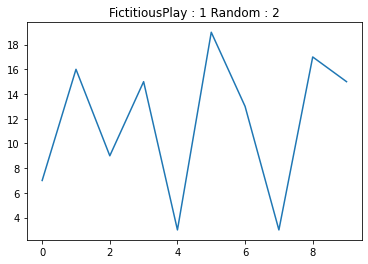

[DEBUG] (Player 0  ) Expected utility  [1.21875  1.078125 1.515625 1.1875  ]
[DEBUG] (Player 0  ) Expected utility  [1.24025974 0.93668831 1.71266234 1.61201299]
[DEBUG] (Player 0  ) Expected utility  [0.99387755 0.73877551 2.77755102 1.33163265]
[DEBUG] (Player 0  ) Expected utility  [0.99387755 0.73877551 2.77755102 1.33163265]
[DEBUG] (Player 0  ) Expected utility  [0.82823129 0.61564626 3.47193878 1.10969388]
[DEBUG] (Player 0  ) Expected utility  [0.82823129 0.61564626 3.47193878 1.10969388]
[DEBUG] (Player 0  ) Expected utility  [0.70991254 0.52769679 3.96793003 0.95116618]
[DEBUG] (Player 0  ) Expected utility  [0.70991254 0.52769679 3.96793003 0.95116618]
[DEBUG] (Player 0  ) Expected utility  [0.62117347 0.46173469 4.33992347 0.83227041]
[DEBUG] (Player 0  ) Expected utility  [0.62117347 0.46173469 4.33992347 0.83227041]
[DEBUG] (Player 0  ) Expected utility  [0.5521542  0.41043084 4.6292517  0.73979592]
[DEBUG] (Player 0  ) Expected utility  [0.5521542  0.41043084 4.6292517  

[DEBUG] (Player 0  ) Expected utility  [0.08686161 0.06558642 6.19867838 0.10595389]
[DEBUG] (Player 0  ) Expected utility  [0.08686161 0.06558642 6.19867838 0.10595389]
[DEBUG] (Player 0  ) Expected utility  [0.08522271 0.06434894 6.20583896 0.10395476]
[DEBUG] (Player 0  ) Expected utility  [0.08522271 0.06434894 6.20583896 0.10395476]
[DEBUG] (Player 0  ) Expected utility  [0.08364452 0.06315729 6.21273434 0.10202967]
[DEBUG] (Player 0  ) Expected utility  [0.08509205 0.06233724 6.0759413  0.09747541]
[DEBUG] (Player 0  ) Expected utility  [0.08354492 0.06120384 6.08243963 0.09570312]
[DEBUG] (Player 0  ) Expected utility  [0.08354492 0.06120384 6.08243963 0.09570312]
[DEBUG] (Player 0  ) Expected utility  [0.08205305 0.06011091 6.08870588 0.09399414]
[DEBUG] (Player 0  ) Expected utility  [0.08205305 0.06011091 6.08870588 0.09399414]
[DEBUG] (Player 0  ) Expected utility  [0.08061352 0.05905633 6.09475226 0.09234512]
[DEBUG] (Player 0  ) Expected utility  [0.08061352 0.05905633 6.0

[DEBUG] (Player 0  ) Expected utility  [0.04274408 0.03429826 6.19451183 0.05101794]
[DEBUG] (Player 0  ) Expected utility  [0.04232087 0.03395868 6.19640869 0.05051281]
[DEBUG] (Player 0  ) Expected utility  [0.04232087 0.03395868 6.19640869 0.05051281]
[DEBUG] (Player 0  ) Expected utility  [0.04190596 0.03362575 6.19826836 0.05001758]
[DEBUG] (Player 0  ) Expected utility  [0.04190596 0.03362575 6.19826836 0.05001758]
[DEBUG] (Player 0  ) Expected utility  [0.04149911 0.03329928 6.20009192 0.04953198]
[DEBUG] (Player 0  ) Expected utility  [0.04149911 0.03329928 6.20009192 0.04953198]


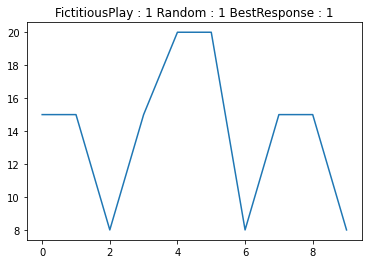

[DEBUG] (Player 0  ) Expected utility  [1.140625 0.875    1.0625   0.984375]
[DEBUG] (Player 0  ) Expected utility  [1.40688776 0.50255102 1.49744898 1.25765306]
[DEBUG] (Player 0  ) Expected utility  [1.1255102  0.40204082 2.39591837 1.00612245]
[DEBUG] (Player 0  ) Expected utility  [1.1255102  0.40204082 2.39591837 1.00612245]
[DEBUG] (Player 0  ) Expected utility  [0.93792517 0.33503401 2.99489796 0.83843537]
[DEBUG] (Player 0  ) Expected utility  [0.93792517 0.33503401 2.99489796 0.83843537]
[DEBUG] (Player 0  ) Expected utility  [0.80393586 0.28717201 3.42274052 0.71865889]
[DEBUG] (Player 0  ) Expected utility  [0.80393586 0.28717201 3.42274052 0.71865889]
[DEBUG] (Player 0  ) Expected utility  [0.70344388 0.25127551 3.74362245 0.62882653]
[DEBUG] (Player 0  ) Expected utility  [0.70344388 0.25127551 3.74362245 0.62882653]
[DEBUG] (Player 0  ) Expected utility  [0.62528345 0.22335601 3.99319728 0.55895692]
[DEBUG] (Player 0  ) Expected utility  [0.62528345 0.22335601 3.99319728 

[DEBUG] (Player 0  ) Expected utility  [0.10691015 0.05004221 5.0967342  0.09190013]
[DEBUG] (Player 0  ) Expected utility  [0.10489298 0.04909801 5.10262184 0.09016616]
[DEBUG] (Player 0  ) Expected utility  [0.10489298 0.04909801 5.10262184 0.09016616]
[DEBUG] (Player 0  ) Expected utility  [0.10295052 0.04818879 5.10829142 0.08849642]
[DEBUG] (Player 0  ) Expected utility  [0.10363005 0.05003683 5.09034091 0.09035143]
[DEBUG] (Player 0  ) Expected utility  [0.09482866 0.05208629 4.96709872 0.08594194]
[DEBUG] (Player 0  ) Expected utility  [0.09482866 0.05208629 4.96709872 0.08594194]
[DEBUG] (Player 0  ) Expected utility  [0.09313529 0.05115618 4.97221592 0.08440726]
[DEBUG] (Player 0  ) Expected utility  [0.09313529 0.05115618 4.97221592 0.08440726]
[DEBUG] (Player 0  ) Expected utility  [0.09150134 0.0502587  4.97715358 0.08292643]
[DEBUG] (Player 0  ) Expected utility  [0.09150134 0.0502587  4.97715358 0.08292643]
[DEBUG] (Player 0  ) Expected utility  [0.08992373 0.04939217 4.9

[DEBUG] (Player 0  ) Expected utility  [0.04315755 0.03189627 4.89400741 0.04405007]
[DEBUG] (Player 0  ) Expected utility  [0.04315755 0.03189627 4.89400741 0.04405007]
[DEBUG] (Player 0  ) Expected utility  [0.04273444 0.03158357 4.8954762  0.04361821]
[DEBUG] (Player 0  ) Expected utility  [0.04273444 0.03158357 4.8954762  0.04361821]
[DEBUG] (Player 0  ) Expected utility  [0.04231954 0.03127693 4.89691647 0.04319473]
[DEBUG] (Player 0  ) Expected utility  [0.04231954 0.03127693 4.89691647 0.04319473]


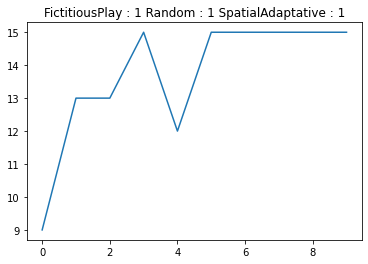

[DEBUG] (Player 0  ) Expected utility  [1.28125  1.453125 1.171875 1.46875 ]
[DEBUG] (Player 0  ) Expected utility  [1.30357143 1.31730769 1.34478022 1.62225275]
[DEBUG] (Player 0  ) Expected utility  [1.06530612 1.05204082 1.07244898 2.63265306]
[DEBUG] (Player 0  ) Expected utility  [1.06530612 1.05204082 1.07244898 2.63265306]
[DEBUG] (Player 0  ) Expected utility  [0.8877551  0.87670068 0.89370748 3.29081633]
[DEBUG] (Player 0  ) Expected utility  [0.8877551  0.87670068 0.89370748 3.29081633]
[DEBUG] (Player 0  ) Expected utility  [0.76093294 0.75145773 0.76603499 3.76093294]
[DEBUG] (Player 0  ) Expected utility  [0.76093294 0.75145773 0.76603499 3.76093294]
[DEBUG] (Player 0  ) Expected utility  [0.66581633 0.65752551 0.67028061 4.11352041]
[DEBUG] (Player 0  ) Expected utility  [0.66581633 0.65752551 0.67028061 4.11352041]
[DEBUG] (Player 0  ) Expected utility  [0.59183673 0.58446712 0.59580499 4.3877551 ]
[DEBUG] (Player 0  ) Expected utility  [0.59183673 0.58446712 0.59580499 

[DEBUG] (Player 0  ) Expected utility  [0.1287591  0.08436873 0.06650971 5.46447979]
[DEBUG] (Player 0  ) Expected utility  [0.12632968 0.08277687 0.06525481 5.47079225]
[DEBUG] (Player 0  ) Expected utility  [0.12632968 0.08277687 0.06525481 5.47079225]
[DEBUG] (Player 0  ) Expected utility  [0.12399025 0.08124397 0.06404639 5.4768709 ]
[DEBUG] (Player 0  ) Expected utility  [0.1259838  0.08098476 0.06230228 5.41235532]
[DEBUG] (Player 0  ) Expected utility  [0.12492898 0.0786266  0.06150124 5.38050426]
[DEBUG] (Player 0  ) Expected utility  [0.12492898 0.0786266  0.06150124 5.38050426]
[DEBUG] (Player 0  ) Expected utility  [0.1226981  0.07722255 0.06040301 5.38604736]
[DEBUG] (Player 0  ) Expected utility  [0.1226981  0.07722255 0.06040301 5.38604736]
[DEBUG] (Player 0  ) Expected utility  [0.1205455  0.07586777 0.0593433  5.39139597]
[DEBUG] (Player 0  ) Expected utility  [0.1205455  0.07586777 0.0593433  5.39139597]
[DEBUG] (Player 0  ) Expected utility  [0.11846713 0.07455971 0.0

[DEBUG] (Player 0  ) Expected utility  [0.07197258 0.04155285 0.03197958 5.28478162]
[DEBUG] (Player 0  ) Expected utility  [0.07197258 0.04155285 0.03197958 5.28478162]
[DEBUG] (Player 0  ) Expected utility  [0.07126697 0.04114547 0.03166605 5.28636769]
[DEBUG] (Player 0  ) Expected utility  [0.07126697 0.04114547 0.03166605 5.28636769]
[DEBUG] (Player 0  ) Expected utility  [0.07057506 0.040746   0.03135861 5.28792296]
[DEBUG] (Player 0  ) Expected utility  [0.07057506 0.040746   0.03135861 5.28792296]


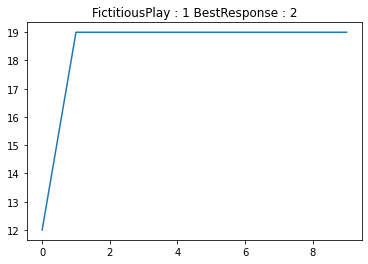

[DEBUG] (Player 0  ) Expected utility  [1.328125 1.125    1.203125 0.953125]
[DEBUG] (Player 0  ) Expected utility  [1.3125 1.0875 1.275  1.0375]
[DEBUG] (Player 0  ) Expected utility  [2.0755102  1.21428571 0.85510204 0.96326531]
[DEBUG] (Player 0  ) Expected utility  [2.0755102  1.21428571 0.85510204 0.96326531]
[DEBUG] (Player 0  ) Expected utility  [2.59438776 1.01190476 0.71258503 0.80272109]
[DEBUG] (Player 0  ) Expected utility  [2.59438776 1.01190476 0.71258503 0.80272109]
[DEBUG] (Player 0  ) Expected utility  [2.96501458 0.86734694 0.61078717 0.68804665]
[DEBUG] (Player 0  ) Expected utility  [2.96501458 0.86734694 0.61078717 0.68804665]
[DEBUG] (Player 0  ) Expected utility  [3.24298469 0.75892857 0.53443878 0.60204082]
[DEBUG] (Player 0  ) Expected utility  [3.24298469 0.75892857 0.53443878 0.60204082]
[DEBUG] (Player 0  ) Expected utility  [3.45918367 0.67460317 0.47505669 0.53514739]
[DEBUG] (Player 0  ) Expected utility  [3.45918367 0.67460317 0.47505669 0.53514739]
[DEB

[DEBUG] (Player 0  ) Expected utility  [5.35008441 0.09992614 0.1039886  0.11633428]
[DEBUG] (Player 0  ) Expected utility  [5.35626472 0.09804074 0.10202655 0.1141393 ]
[DEBUG] (Player 0  ) Expected utility  [5.35626472 0.09804074 0.10202655 0.1141393 ]
[DEBUG] (Player 0  ) Expected utility  [5.36221613 0.09622517 0.10013717 0.11202561]
[DEBUG] (Player 0  ) Expected utility  [5.44284664 0.09885065 0.09902641 0.1106371 ]
[DEBUG] (Player 0  ) Expected utility  [5.4446733  0.09537464 0.09870384 0.11022727]
[DEBUG] (Player 0  ) Expected utility  [5.4446733  0.09537464 0.09870384 0.11022727]
[DEBUG] (Player 0  ) Expected utility  [5.45028251 0.09367153 0.09694127 0.10825893]
[DEBUG] (Player 0  ) Expected utility  [5.45028251 0.09367153 0.09694127 0.10825893]
[DEBUG] (Player 0  ) Expected utility  [5.4556949  0.09202817 0.09524054 0.10635965]
[DEBUG] (Player 0  ) Expected utility  [5.4556949  0.09202817 0.09524054 0.10635965]
[DEBUG] (Player 0  ) Expected utility  [5.46092066 0.09044147 0.0

[DEBUG] (Player 0  ) Expected utility  [5.15640745 0.05394374 0.04976035 0.05866263]
[DEBUG] (Player 0  ) Expected utility  [5.15640745 0.05394374 0.04976035 0.05866263]
[DEBUG] (Player 0  ) Expected utility  [5.15795499 0.05341488 0.0492725  0.05808751]
[DEBUG] (Player 0  ) Expected utility  [5.15795499 0.05341488 0.0492725  0.05808751]
[DEBUG] (Player 0  ) Expected utility  [5.15947248 0.05289628 0.04879413 0.05752355]
[DEBUG] (Player 0  ) Expected utility  [5.15947248 0.05289628 0.04879413 0.05752355]


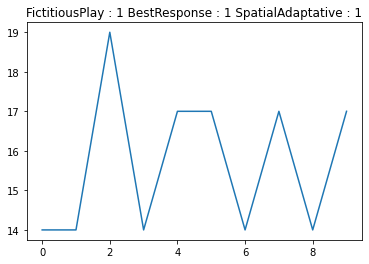

[DEBUG] (Player 0  ) Expected utility  [0.90625  1.53125  1.203125 1.125   ]
[DEBUG] (Player 0  ) Expected utility  [1.04166667 1.56944444 0.92361111 1.33333333]
[DEBUG] (Player 0  ) Expected utility  [0.88333333 2.70666667 0.44833333 1.22666667]
[DEBUG] (Player 0  ) Expected utility  [1.03571429 2.3877551  0.74693878 1.28571429]
[DEBUG] (Player 0  ) Expected utility  [0.86309524 2.98469388 0.62244898 1.07142857]
[DEBUG] (Player 0  ) Expected utility  [0.86309524 2.98469388 0.62244898 1.07142857]
[DEBUG] (Player 0  ) Expected utility  [0.73979592 3.41107872 0.5335277  0.91836735]
[DEBUG] (Player 0  ) Expected utility  [0.73979592 3.41107872 0.5335277  0.91836735]
[DEBUG] (Player 0  ) Expected utility  [0.64732143 3.73086735 0.46683673 0.80357143]
[DEBUG] (Player 0  ) Expected utility  [0.64732143 3.73086735 0.46683673 0.80357143]
[DEBUG] (Player 0  ) Expected utility  [0.57539683 3.97959184 0.41496599 0.71428571]
[DEBUG] (Player 0  ) Expected utility  [0.57539683 3.97959184 0.41496599 

[DEBUG] (Player 0  ) Expected utility  [0.0705458  7.09380606 0.10602643 0.0757228 ]
[DEBUG] (Player 0  ) Expected utility  [0.06921474 7.10200067 0.10402593 0.07429407]
[DEBUG] (Player 0  ) Expected utility  [0.06921474 7.10200067 0.10402593 0.07429407]
[DEBUG] (Player 0  ) Expected utility  [0.06793299 7.10989178 0.10209953 0.07291825]
[DEBUG] (Player 0  ) Expected utility  [0.06621664 7.0449787  0.10223089 0.07472986]
[DEBUG] (Player 0  ) Expected utility  [0.06096413 7.03551136 0.10364879 0.07397017]
[DEBUG] (Player 0  ) Expected utility  [0.06096413 7.03551136 0.10364879 0.07397017]
[DEBUG] (Player 0  ) Expected utility  [0.05987549 7.04275949 0.10179792 0.07264927]
[DEBUG] (Player 0  ) Expected utility  [0.05987549 7.04275949 0.10179792 0.07264927]
[DEBUG] (Player 0  ) Expected utility  [0.05882504 7.04975329 0.10001199 0.07137473]
[DEBUG] (Player 0  ) Expected utility  [0.05882504 7.04975329 0.10001199 0.07137473]
[DEBUG] (Player 0  ) Expected utility  [0.05781082 7.05650593 0.0

[DEBUG] (Player 0  ) Expected utility  [0.03026137 7.32531197 0.05736826 0.03784639]
[DEBUG] (Player 0  ) Expected utility  [0.03026137 7.32531197 0.05736826 0.03784639]
[DEBUG] (Player 0  ) Expected utility  [0.02996469 7.32751044 0.05680582 0.03747535]
[DEBUG] (Player 0  ) Expected utility  [0.02996469 7.32751044 0.05680582 0.03747535]
[DEBUG] (Player 0  ) Expected utility  [0.02967377 7.32966623 0.05625431 0.03711151]
[DEBUG] (Player 0  ) Expected utility  [0.02967377 7.32966623 0.05625431 0.03711151]


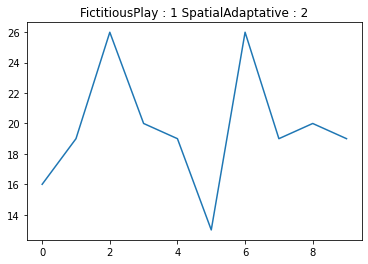

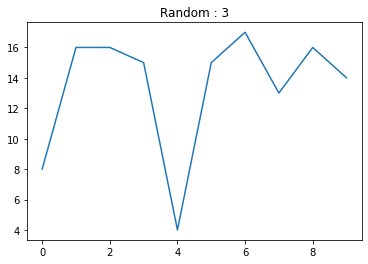

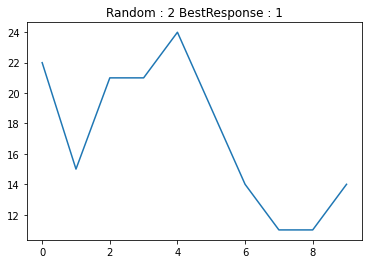

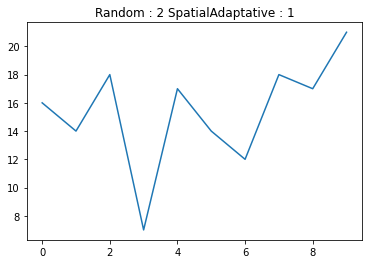

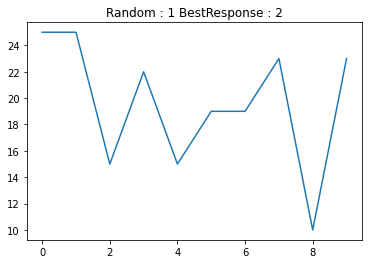

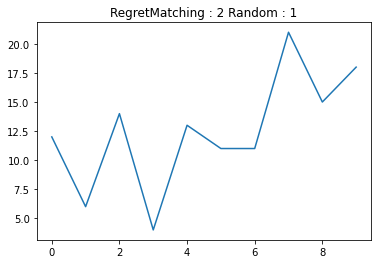

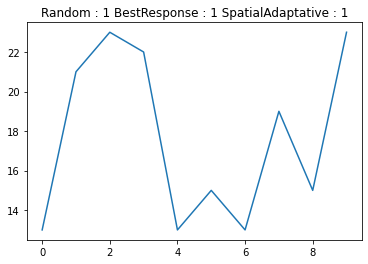

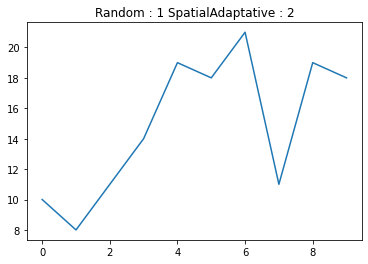

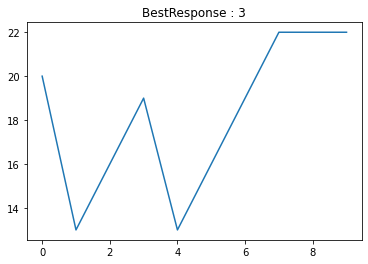

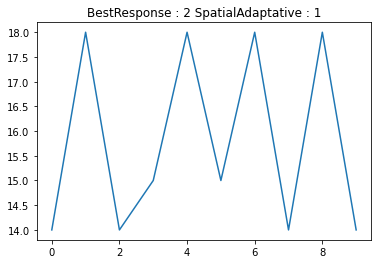

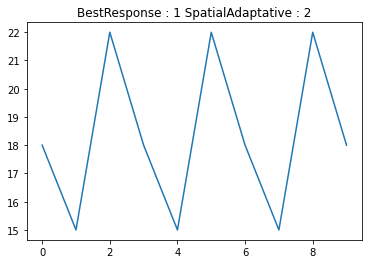

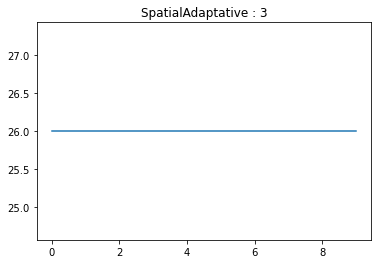

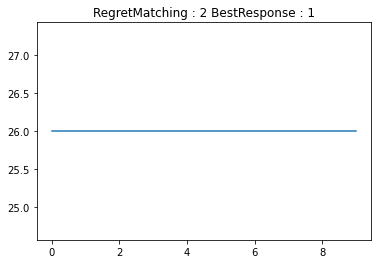

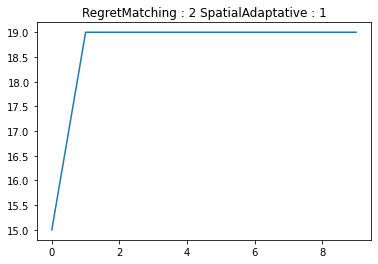

[DEBUG] (Player 1  ) Expected utility  [1.45138889 1.28472222 1.16666667 1.15277778]
[DEBUG] (Player 1  ) Expected utility  [1.53571429 1.33928571 1.15178571 1.09821429]
[DEBUG] (Player 2  ) Expected utility  [1.19642857 1.19196429 1.01785714 1.125     ]
[DEBUG] (Player 1  ) Expected utility  [2.45714286 1.07142857 0.92142857 0.87857143]
[DEBUG] (Player 2  ) Expected utility  [1.09642857 1.07142857 1.06071429 1.24642857]
[DEBUG] (Player 1  ) Expected utility  [2.45714286 1.07142857 0.92142857 0.87857143]
[DEBUG] (Player 2  ) Expected utility  [0.87714286 0.85714286 0.84857143 1.99428571]
[DEBUG] (Player 1  ) Expected utility  [2.96428571 0.90952381 0.75714286 0.6547619 ]
[DEBUG] (Player 2  ) Expected utility  [0.82380952 0.79285714 0.87142857 2.12380952]
[DEBUG] (Player 1  ) Expected utility  [2.96428571 0.90952381 0.75714286 0.6547619 ]
[DEBUG] (Player 2  ) Expected utility  [0.68650794 0.66071429 0.72619048 2.6547619 ]
[DEBUG] (Player 1  ) Expected utility  [3.30612245 0.78911565 0.6

[DEBUG] (Player 1  ) Expected utility  [4.31234994 0.18704982 0.11018157 0.14942227]
[DEBUG] (Player 2  ) Expected utility  [0.086247   0.1855117  0.16319028 5.29993247]
[DEBUG] (Player 1  ) Expected utility  [4.33019415 0.18059983 0.10638221 0.14426978]
[DEBUG] (Player 2  ) Expected utility  [0.08584468 0.18545349 0.16324978 5.30824399]
[DEBUG] (Player 1  ) Expected utility  [4.33019415 0.18059983 0.10638221 0.14426978]
[DEBUG] (Player 2  ) Expected utility  [0.08288452 0.17905854 0.15762048 5.33020913]
[DEBUG] (Player 1  ) Expected utility  [4.34482759 0.17464503 0.10267072 0.13931711]
[DEBUG] (Player 1  ) Expected utility  [4.34482759 0.17464503 0.10267072 0.13931711]
[DEBUG] (Player 2  ) Expected utility  [0.08252197 0.17900609 0.1576741  5.33799865]
[DEBUG] (Player 1  ) Expected utility  [4.36040044 0.16901132 0.09935876 0.13482301]
[DEBUG] (Player 2  ) Expected utility  [0.07944339 0.17299178 0.15246679 5.3658444 ]
[DEBUG] (Player 1  ) Expected utility  [4.35850727 0.16907021 0.0

[DEBUG] (Player 2  ) Expected utility  [0.03515984 0.11708527 0.1026363  5.04377852]
[DEBUG] (Player 1  ) Expected utility  [4.59893566 0.11870397 0.06542628 0.06459308]
[DEBUG] (Player 2  ) Expected utility  [0.03509515 0.11708461 0.10265817 5.04454927]
[DEBUG] (Player 1  ) Expected utility  [4.59893566 0.11870397 0.06542628 0.06459308]
[DEBUG] (Player 1  ) Expected utility  [4.6037477  0.11650749 0.06416777 0.06335249]
[DEBUG] (Player 1  ) Expected utility  [4.6037477  0.11650749 0.06416777 0.06335249]
[DEBUG] (Player 1  ) Expected utility  [4.61353616 0.11537331 0.06341245 0.0613181 ]
[DEBUG] (Player 2  ) Expected utility  [0.03305327 0.11816987 0.10347508 4.93647119]
[DEBUG] (Player 2  ) Expected utility  [0.03233775 0.12000064 0.10498114 4.8717046 ]
[DEBUG] (Player 1  ) Expected utility  [4.62930813 0.11882716 0.06487376 0.05841157]
[DEBUG] (Player 2  ) Expected utility  [0.03174979 0.11781881 0.10307239 4.87691498]
[DEBUG] (Player 1  ) Expected utility  [4.63380165 0.11671488 0.0

[DEBUG] (Player 2  ) Expected utility  [0.02050174 0.08995704 0.07871342 4.71352895]
[DEBUG] (Player 1  ) Expected utility  [4.73052762 0.08803665 0.04696604 0.03734377]
[DEBUG] (Player 2  ) Expected utility  [0.02023548 0.08878876 0.07769117 4.71604462]
[DEBUG] (Player 1  ) Expected utility  [4.73030865 0.08805789 0.04695845 0.03733666]
[DEBUG] (Player 2  ) Expected utility  [0.02023548 0.08878876 0.07769117 4.71604462]
[DEBUG] (Player 1  ) Expected utility  [4.73276723 0.08692894 0.04635642 0.03685798]
[DEBUG] (Player 1  ) Expected utility  [4.73255377 0.08694938 0.04634913 0.03685115]
[DEBUG] (Player 2  ) Expected utility  [0.01995672 0.08765184 0.07670392 4.71831854]
[DEBUG] (Player 1  ) Expected utility  [4.73495    0.08584875 0.04576243 0.03638468]
[DEBUG] (Player 2  ) Expected utility  [0.01993787 0.0876532  0.07671249 4.71814578]
[DEBUG] (Player 1  ) Expected utility  [4.73495    0.08584875 0.04576243 0.03638468]
[DEBUG] (Player 2  ) Expected utility  [0.01968549 0.08654367 0.0

[DEBUG] (Player 2  ) Expected utility  [0.01445354 0.07058264 0.0617679  4.6010358 ]
[DEBUG] (Player 1  ) Expected utility  [4.79059955 0.06871795 0.03614913 0.02651678]
[DEBUG] (Player 2  ) Expected utility  [0.01444476 0.07058352 0.06177225 4.60082485]
[DEBUG] (Player 1  ) Expected utility  [4.79059955 0.06871795 0.03614913 0.02651678]
[DEBUG] (Player 2  ) Expected utility  [0.01430174 0.06988468 0.06116064 4.6022337 ]
[DEBUG] (Player 1  ) Expected utility  [4.79188696 0.06806099 0.03579496 0.02625629]
[DEBUG] (Player 2  ) Expected utility  [0.01429321 0.06988554 0.06116486 4.60202678]
[DEBUG] (Player 1  ) Expected utility  [4.79188696 0.06806099 0.03579496 0.02625629]
[DEBUG] (Player 2  ) Expected utility  [0.01415308 0.06920038 0.06056521 4.60340794]
[DEBUG] (Player 2  ) Expected utility  [0.0141448  0.06920122 0.06056931 4.60320495]
[DEBUG] (Player 2  ) Expected utility  [0.01400748 0.06852936 0.05998126 4.60455923]
[DEBUG] (Player 2  ) Expected utility  [0.01400748 0.06852936 0.0

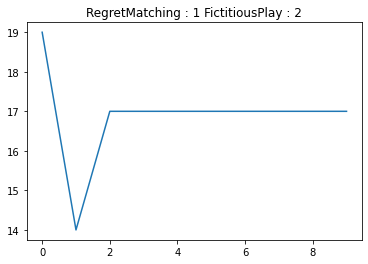

[DEBUG] (Player 1  ) Expected utility  [1.4375     0.46428571 0.87053571 1.10714286]
[DEBUG] (Player 1  ) Expected utility  [1.59566327 0.47193878 0.91964286 1.13265306]
[DEBUG] (Player 1  ) Expected utility  [2.55306122 0.37755102 0.73571429 0.90612245]
[DEBUG] (Player 1  ) Expected utility  [2.55306122 0.37755102 0.73571429 0.90612245]
[DEBUG] (Player 1  ) Expected utility  [3.19132653 0.31462585 0.61309524 0.75510204]
[DEBUG] (Player 1  ) Expected utility  [3.19132653 0.31462585 0.61309524 0.75510204]
[DEBUG] (Player 1  ) Expected utility  [3.64723032 0.2696793  0.5255102  0.64723032]
[DEBUG] (Player 1  ) Expected utility  [3.64723032 0.2696793  0.5255102  0.64723032]
[DEBUG] (Player 1  ) Expected utility  [3.98915816 0.23596939 0.45982143 0.56632653]
[DEBUG] (Player 1  ) Expected utility  [3.98915816 0.23596939 0.45982143 0.56632653]
[DEBUG] (Player 1  ) Expected utility  [4.25510204 0.20975057 0.40873016 0.50340136]
[DEBUG] (Player 1  ) Expected utility  [4.25510204 0.20975057 0.4

[DEBUG] (Player 1  ) Expected utility  [5.40857471 0.08022713 0.06857392 0.09284979]
[DEBUG] (Player 1  ) Expected utility  [5.41482258 0.07871341 0.06728007 0.09109791]
[DEBUG] (Player 1  ) Expected utility  [5.41482258 0.07871341 0.06728007 0.09109791]
[DEBUG] (Player 1  ) Expected utility  [5.33160061 0.07858638 0.06560898 0.08860371]
[DEBUG] (Player 1  ) Expected utility  [5.14463976 0.08383066 0.06286621 0.08778664]
[DEBUG] (Player 1  ) Expected utility  [5.15014205 0.08230646 0.06172319 0.08619052]
[DEBUG] (Player 1  ) Expected utility  [5.15014205 0.08230646 0.06172319 0.08619052]
[DEBUG] (Player 1  ) Expected utility  [5.15544782 0.0808367  0.06062099 0.0846514 ]
[DEBUG] (Player 1  ) Expected utility  [5.15544782 0.0808367  0.06062099 0.0846514 ]
[DEBUG] (Player 1  ) Expected utility  [5.16056743 0.07941852 0.05955746 0.08316629]
[DEBUG] (Player 1  ) Expected utility  [5.16056743 0.07941852 0.05955746 0.08316629]
[DEBUG] (Player 1  ) Expected utility  [5.16551051 0.07804923 0.0

[DEBUG] (Player 1  ) Expected utility  [5.13837586 0.0412407  0.03540135 0.0478554 ]
[DEBUG] (Player 1  ) Expected utility  [5.13837586 0.0412407  0.03540135 0.0478554 ]
[DEBUG] (Player 1  ) Expected utility  [5.13991799 0.04083638 0.03505428 0.04738623]
[DEBUG] (Player 1  ) Expected utility  [5.13991799 0.04083638 0.03505428 0.04738623]
[DEBUG] (Player 1  ) Expected utility  [5.14143017 0.04043991 0.03471394 0.04692616]
[DEBUG] (Player 1  ) Expected utility  [5.14143017 0.04043991 0.03471394 0.04692616]


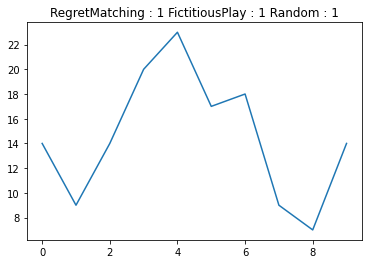

[DEBUG] (Player 1  ) Expected utility  [0.85416667 1.28125    1.5625     0.8125    ]
[DEBUG] (Player 1  ) Expected utility  [1.46683673 1.66964286 1.79336735 0.46683673]
[DEBUG] (Player 1  ) Expected utility  [1.17346939 1.33571429 2.86938776 0.37346939]
[DEBUG] (Player 1  ) Expected utility  [1.17346939 1.33571429 2.86938776 0.37346939]
[DEBUG] (Player 1  ) Expected utility  [0.97789116 1.11309524 3.58673469 0.31122449]
[DEBUG] (Player 1  ) Expected utility  [0.97789116 1.11309524 3.58673469 0.31122449]
[DEBUG] (Player 1  ) Expected utility  [0.83819242 0.95408163 4.09912536 0.26676385]
[DEBUG] (Player 1  ) Expected utility  [0.83819242 0.95408163 4.09912536 0.26676385]
[DEBUG] (Player 1  ) Expected utility  [0.73341837 0.83482143 4.48341837 0.23341837]
[DEBUG] (Player 1  ) Expected utility  [0.73341837 0.83482143 4.48341837 0.23341837]
[DEBUG] (Player 1  ) Expected utility  [0.65192744 0.74206349 4.78231293 0.20748299]
[DEBUG] (Player 1  ) Expected utility  [0.65192744 0.74206349 4.7

[DEBUG] (Player 1  ) Expected utility  [0.09768387 0.05038514 4.62751926 0.12188061]
[DEBUG] (Player 1  ) Expected utility  [0.09584077 0.04943448 4.63286487 0.11958097]
[DEBUG] (Player 1  ) Expected utility  [0.09584077 0.04943448 4.63286487 0.11958097]
[DEBUG] (Player 1  ) Expected utility  [0.09449327 0.04603474 4.59030829 0.11863826]
[DEBUG] (Player 1  ) Expected utility  [0.0981174  0.04385489 4.5054796  0.12438061]
[DEBUG] (Player 1  ) Expected utility  [0.09633345 0.04305753 4.5102983  0.12211914]
[DEBUG] (Player 1  ) Expected utility  [0.09633345 0.04305753 4.5102983  0.12211914]
[DEBUG] (Player 1  ) Expected utility  [0.09461321 0.04228864 4.51494489 0.11993844]
[DEBUG] (Player 1  ) Expected utility  [0.09461321 0.04228864 4.51494489 0.11993844]
[DEBUG] (Player 1  ) Expected utility  [0.09295333 0.04154674 4.51942845 0.11783426]
[DEBUG] (Player 1  ) Expected utility  [0.09295333 0.04154674 4.51942845 0.11783426]
[DEBUG] (Player 1  ) Expected utility  [0.09135069 0.04083041 4.5

[DEBUG] (Player 1  ) Expected utility  [0.05791017 0.01825312 4.34372986 0.0747252 ]
[DEBUG] (Player 1  ) Expected utility  [0.05791017 0.01825312 4.34372986 0.0747252 ]
[DEBUG] (Player 1  ) Expected utility  [0.05734243 0.01807417 4.3450335  0.0739926 ]
[DEBUG] (Player 1  ) Expected utility  [0.05734243 0.01807417 4.3450335  0.0739926 ]
[DEBUG] (Player 1  ) Expected utility  [0.0567857  0.01789869 4.34631183 0.07327422]
[DEBUG] (Player 1  ) Expected utility  [0.0567857  0.01789869 4.34631183 0.07327422]


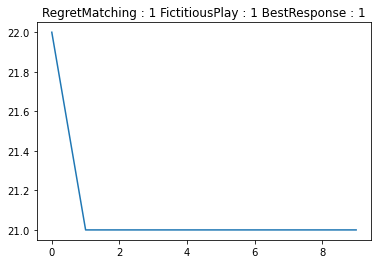

[DEBUG] (Player 1  ) Expected utility  [1.04910714 1.18303571 1.33482143 1.02678571]
[DEBUG] (Player 1  ) Expected utility  [1.37117347 1.72831633 0.87882653 0.89285714]
[DEBUG] (Player 1  ) Expected utility  [1.09693878 2.76530612 0.70306122 0.71428571]
[DEBUG] (Player 1  ) Expected utility  [1.09693878 2.76530612 0.70306122 0.71428571]
[DEBUG] (Player 1  ) Expected utility  [0.91411565 3.45663265 0.58588435 0.5952381 ]
[DEBUG] (Player 1  ) Expected utility  [0.91411565 3.45663265 0.58588435 0.5952381 ]
[DEBUG] (Player 1  ) Expected utility  [0.7835277  3.95043732 0.50218659 0.51020408]
[DEBUG] (Player 1  ) Expected utility  [0.7835277  3.95043732 0.50218659 0.51020408]
[DEBUG] (Player 1  ) Expected utility  [0.68558673 4.32079082 0.43941327 0.44642857]
[DEBUG] (Player 1  ) Expected utility  [0.68558673 4.32079082 0.43941327 0.44642857]
[DEBUG] (Player 1  ) Expected utility  [0.60941043 4.60884354 0.39058957 0.3968254 ]
[DEBUG] (Player 1  ) Expected utility  [0.60941043 4.60884354 0.3

[DEBUG] (Player 1  ) Expected utility  [0.10104068 6.11595178 0.09809935 0.11368313]
[DEBUG] (Player 1  ) Expected utility  [0.09913425 6.1230168  0.09624841 0.11153816]
[DEBUG] (Player 1  ) Expected utility  [0.09913425 6.1230168  0.09624841 0.11153816]
[DEBUG] (Player 1  ) Expected utility  [0.09777272 6.11833081 0.09433134 0.10982962]
[DEBUG] (Player 1  ) Expected utility  [0.09671134 6.18085395 0.09681984 0.11026114]
[DEBUG] (Player 1  ) Expected utility  [0.09495295 6.18746449 0.09505948 0.10825639]
[DEBUG] (Player 1  ) Expected utility  [0.09495295 6.18746449 0.09505948 0.10825639]
[DEBUG] (Player 1  ) Expected utility  [0.09325736 6.19383894 0.09336199 0.10632324]
[DEBUG] (Player 1  ) Expected utility  [0.09325736 6.19383894 0.09336199 0.10632324]
[DEBUG] (Player 1  ) Expected utility  [0.09162127 6.19998972 0.09172406 0.10445792]
[DEBUG] (Player 1  ) Expected utility  [0.09162127 6.19998972 0.09172406 0.10445792]
[DEBUG] (Player 1  ) Expected utility  [0.09004159 6.20592841 0.0

[DEBUG] (Player 1  ) Expected utility  [0.05096136 6.48832313 0.05453509 0.05949016]
[DEBUG] (Player 1  ) Expected utility  [0.05096136 6.48832313 0.05453509 0.05949016]
[DEBUG] (Player 1  ) Expected utility  [0.05046173 6.49027041 0.05400043 0.05890692]
[DEBUG] (Player 1  ) Expected utility  [0.05046173 6.49027041 0.05400043 0.05890692]
[DEBUG] (Player 1  ) Expected utility  [0.04997181 6.49217987 0.05347615 0.05833501]
[DEBUG] (Player 1  ) Expected utility  [0.04997181 6.49217987 0.05347615 0.05833501]


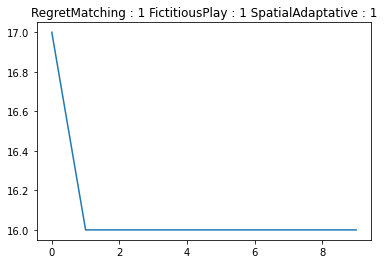

In [20]:
import matplotlib.pyplot as plt 

# run all the experiments and plot the curve
for exp in myexp.keys():
    utility_evolution = []
    #print(exp)
    nb_sync = myexp[exp]["nb_sync"]
    nb_tasks = myexp[exp]["tasks"]
    agents = []
    entrys = myexp[exp].keys()
    #print(entrys)
    res = []
    for i in entrys : # search for Type definitions only
        if len(re.findall('Type*', i)) > 0 :
            res.append(i)
    total_agents = 0
    for t in res :
        nb_t = myexp[exp][t]["number"] # number of agents of this type
        total_agents += nb_t
    #print(total_agents)
    env = Environnement(nb_tasks,total_agents) #creating the environment
    for t in res :
        if np.isin("spec",myexp[exp][t].keys()): # check if extra parameters
            fadding = myexp[exp][t]["spec"]["fadding"]
            inertia = myexp[exp][t]["spec"]["inertia"]
        else:
            fadding = 0
            inertia = 0
        for j in range(myexp[exp][t]["number"]): #create X agents of this type
            ag = getAgent(env, len(agents),myexp[exp][t]["type"], fadding, inertia)
            agents.append(ag)
    #print(agents)
    for steps in range(10):
        threads = []
        for a in agents : # getting agent threads
            t = threading.Thread(name="Player "+str(a.id), target=a.getWorkerFunction(10,verbose=False))
            threads.append(t)
        for th in threads : #starting the threads
            th.start()
        for th in threads : # join all (wait all ended)
            th.join()
        currentAlloc = env.allocation
        #print("alloc : "+str(currentAlloc))
        currentUt = env.utility[tuple(currentAlloc)]
        #print("utility : "+str(currentUt))
        utility_evolution.append(metric("sum", currentUt))
    plt.figure()
    plt.plot(list(range(len(utility_evolution))), utility_evolution)
    plt.title(" ".join([myexp[exp][t]["type"] + " : "+ str(myexp[exp][t]["number"]) for t in res]))
    plt.show()
    #print(env.is_EN())